# ``gpempy``: a brief overview


    @author: V.Pelgrims
---

The purpose of this script is to have a first contact with ``gpempy`` and see what it is about.

This script contains four main sections showcasting the purpose of each module of ``gpempy`` and give pratical uses of those.
1. `GalaxyBasics`
2. `GalacticProfile`
3. `BFIELD`
4. `GalacticForegrounds`

Before we begin, however, note that all the functions written in the four modules of `gpempy` are documented in a (too?) verbose style. This documentation can be displayed in the Terminal using the command `help(the_function_you_wonder_about)`.  

Note also that `gpempy` has been written in such a way that there are usually several ways to explore a model, estimate fields, etc. allowing for either abstract or technical use of the code, the latter being generally more efficient.  
Also, many of the functions in the modules have parameters with default values, so that executing `the_function_you_wonder_about()` will, in general, return a result.

Let's start with some imports, as always.

In [1]:
# gpempy specific:
import BFIELD as bf                 #magnetic field module
import GalaxyBasics as gb           #template and basic algebra
import GalacticProfile as gp        #density profiles
import GalacticForegrounds as gf    #thermal dust and synchrotron emission

# other very important stuffs:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import yaml

### 1. GalaxyBasics
This module contains many useful functions to handle the different coordinate systems and go from one to the other, both with scalar and vector fields. The only function that a end-user may need is its `GalacticTemplate()` function which serves to creat what is called a 'Galactic template'. The latter consists of a:
- 3D HEALPix grid in the heliocentric reference frame
- the same grid points but in the Galacto-centric reference frame
- **all** dot products between the base vectors of the two reference frames. These products will be useful for projecting the 3D vector field of the Galactic Magnetic Field onto the observer's celestial reference frame in order to calculate the polarization observables.  

The grid points are given in Cartesian coordinate $(X,Y,Z)$ in both heliocentric and Galactocentric reference frame. This grid will be used later, so let's compute it now.

In [2]:
XYZ_sun,XYZ_gal,dotproducts = gb.GalacticTemplate()


    The Galaxy Template has been built with:
        NSIDE =  64 
        radial_step =  0.2 kpc
        radial_max =  20.0 kpc

    The Galactic space is thus populated by 4915200 points
    distributed spherically around the Sun.
    
    Dot products between basis vectors have been computed


The output text speaks for itself. If we want to change the parameters defining the grid (`NSIDE`, `radial_step`, `radial_max`), we can naturally pass them to the function as follows

```Python
XYZ_sun,XYZ_gal = gb.GalacticTemplate(64,0.2,20.,Bfield=False)
```

where we also illustrate that we can avoid the computation of dot products if we don't want them. Have a look at `help(gb.GalacticTemplate)` if you want to see more options, like changing the default Galactic coordinates of the Sun.

### 2. GalacticProfile
This module is used to populate a grid like our Galactic template, or more generally a set of coordinates, with matter density through the use of parametric models to describe the matter density distribution in space.

Below we see how to visualize (in 2D) your favorit model for the matter density distribution.
As we will see, and among other things, ``gpempy`` makes it possible to call, visualize and estimate any implemented model using initialization files (e.g. yaml files) thanks to the use of multiple layers of wrappers among which a dictionary-based approach to controls calls of model functions.

For illustration we will first use a dust density distribution model, made of several components, pre-registered in the initialization file dust_model.yml.

Then we will visualize this model:
- showing a horizontal cross-cut of the Galactic plane, at $Z_{\mathrm{gal}}=0$
- showing a vertical cross-cut in the plane $(X_{\mathrm{gal}}, Z_{\mathrm{gal}})$ at $Y_{\mathrm{gal}} = 0$
- a sky projection of the integrated density distribution, that is, a column density map



  -  Arm 1
  -  Arm 2
  -  Arm 3
  -  Arm 4
  -  Clump 1
  -  Loop 1
  -  Loop 2
  -  cylHalo 1


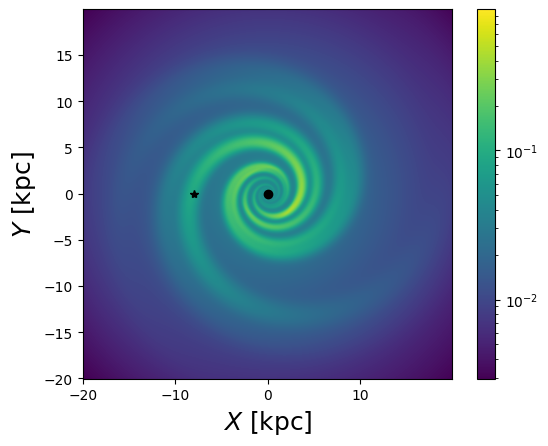



  -  Arm 1
  -  Arm 2
  -  Arm 3
  -  Arm 4
  -  Clump 1
  -  Loop 1
  -  Loop 2
  -  cylHalo 1


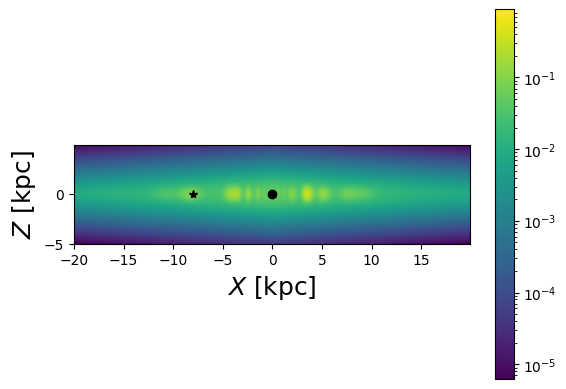

In [3]:
#open a nice configuration of dust density using yaml
with open('dust_model.yml','r') as config:
    dust_model = yaml.safe_load(config)

#visualize your model
# 1. a slice in the Galactic plane [(x,y)-plane]
gp.plot_galactic_dust_xy_slice(dust_model)
# 2. a slice in the (x,z)-plane
gp.plot_galactic_dust_xz_slice(dust_model)
plt.show()

The output text lets us know that the dust density distribution model seems to contain four spiral arms, a clump, two loops and one cylHalo, whatever all this means.
This could have also been inferred by looking into the content of the dictionary

In [4]:
print(dust_model.keys())

dict_keys(['Arm', 'Clump', 'Loop', 'cylHalo'])


and we can find out the values of the parameters of these parameteric models simply by looking after them, e.g., for the second and last:

In [5]:
print(list(dust_model.keys())[1], dust_model[list(dust_model.keys())[1]])
print(list(dust_model.keys())[-1], dust_model[list(dust_model.keys())[-1]])

Clump [{'amplitude': 1.2, 'clumpCentre': [-4.0, -6.2, -3.0], 'radial_scale': 0.3}]
cylHalo [{'amplitude': 0.05, 'height_scale': 1.2, 'radial_scale': 10.0}]


though, so far we don't know are those components and what are their parameterization nor their functional form. We will come into it but first, because it is nice, let's view the projected matter density onto the sky:


    The Galaxy Template has been built with:
        NSIDE =  64 
        radial_step =  0.2 kpc
        radial_max =  20.0 kpc

    The Galactic space is thus populated by 4915200 points
    distributed spherically around the Sun.
    
    Dot products between basis vectors have not been computed


  -  Arm 1
  -  Arm 2
  -  Arm 3
  -  Arm 4
  -  Clump 1
  -  Loop 1
  -  Loop 2
  -  cylHalo 1


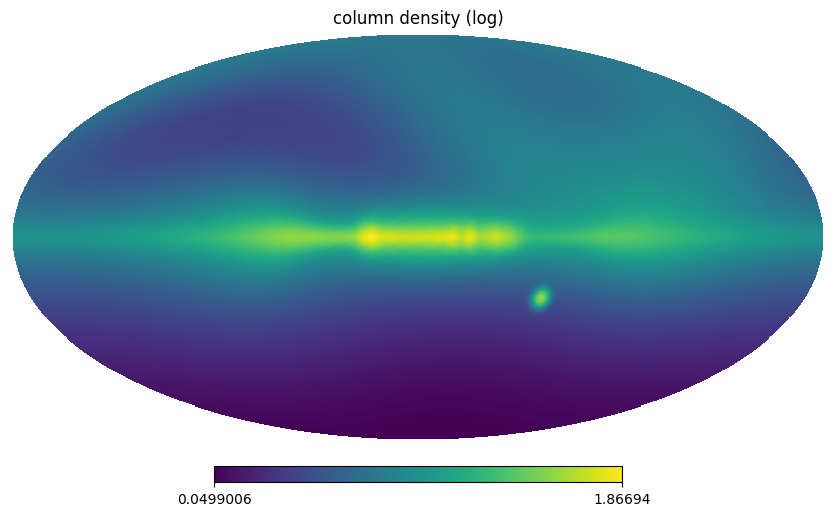

In [6]:
gp.plot_sky_projection(dust_model)
plt.show()

Now, let's dive into the code and see what's behind those "obscure" visualization functions.
If we go into the code, for example of `gp.plot_galactic_dust_xy_slice(dust_model)`, we will find that after the definition of the coordinates of the plane in which to evaluate the density distribution model (`XYZ`) the dictionary of our dust model is passed to a `gp.Duster()` function:
```Python
dust_density = Duster(XYZ,dust_model)
```
This `gp.Duster()` function is our interface to access the different geometrical profiles for the matter (initialy dust) density distribution in a friendly user way. There is a bunch of default settings that one can look for in executing `gp.getDusterDefault('key')` (with `key`) being the name of components.
For example, if we consider the "`cylHalo`" component:

In [7]:
print(gp.getDusterDefault('cylHalo'))

{
	'cylHalo': [
		{
			'amplitude': 1.0,
			'radial_form': 'Decreasing_Exp',
			'radial_scale': 3.0,
			'height_form': 'HyperbolicSecant',
			'height_scale': 1.0
		}
	]
}
None


we see that there are three parameters and two names to control the functional form for the radial and height dependence of the density profile.
To know more about `cylHalo` we then need to look at the documentation of the `gp.cylHaloProfile()` and we learn that
```Python
    """
    The hypothetical halo centred on the origine of the coord. syst. has a
    density profile determined such as

        " cylHalo(coord) = A_0 * func(rho,rho_param) * func(z,z_param)

          where :
            - rho is the radial (cylindrical) coordinate
            - z is the height coordinate

            - func(rho,rho_param) = OneParamFunc(rho,rho_param,rho_func)

            - func(z,z_param) = OneParamFunc(z,z_param,z_func)
            
            FOR Gaussian, Hyperbolic Secant, Decreasing Exponential
                Power Law profile or Cosine.
     """
```
which illustrates the effort put to reach a more general modeling approach allowing the user to explore models in an abstract level, switching from a functional form of the coordinates to another simply through the use of a singl key word thanks to the use of the function `gp.OneParamFunc()`.
Generally this approach is computationaly less efficient that directly referring to hardcoded version of the same models. For example, the `cylHaloProfile` has a hard-coded version in `eGalProfile` where the famous "exponential disk" model is implemented if a more intensive exploration of the parameter space is needed.

Another interesting feature of the implementation is that the user can easily switch from one basis of a coordinate system to another one (e.g., from cylindrical coordinate to spherical) again through the use of simple keywords passed to the functions.

Before to conclude on this section let's just show how we can creat a dictionary corresponding to a density profile we like. The easiest way, perhaps, it to start with the dictionary corresponding to a default setu for one component. Let's consider the `cylHalo` profile. To get the default settings we will use the `gp.getDusterDefault()` function and specifically ask to return the dictionary of interest. Then we will change few things and finaly use `yaml` to save it in this directory as an initialization file that a human can read.

In [8]:
ed = gp.getDusterDefault('cylHalo',output=True)

{
	'cylHalo': [
		{
			'amplitude': 1.0,
			'radial_form': 'Decreasing_Exp',
			'radial_scale': 3.0,
			'height_form': 'HyperbolicSecant',
			'height_scale': 1.0
		}
	]
}


In [9]:
print('Print the returned dictionary:')
print(ed)
print('\n -> Thus we got the directory corresponding to the default')
#
print('\n Now we  change the functional form of the radial coordinate and the scale height')
ed['cylHalo'][0]['radial_form'] = 'Gauss'
ed['cylHalo'][0]['height_scale'] = .3
print(ed)
#
print('\n Oh! And what if we add another such model with different values?')
ed['cylHalo'].append({})
ed['cylHalo'][1]['amplitude'] = .3
ed['cylHalo'][1]['height_scale'] = .9
print(ed)

print("\n and let's put four spiral arms with default settings:")
ed['ARM4'] = [{}]
print(ed)

Print the returned dictionary:
{'cylHalo': [{'amplitude': 1.0, 'radial_form': 'Decreasing_Exp', 'radial_scale': 3.0, 'height_form': 'HyperbolicSecant', 'height_scale': 1.0}]}

 -> Thus we got the directory corresponding to the default

 Now we  change the functional form of the radial coordinate and the scale height
{'cylHalo': [{'amplitude': 1.0, 'radial_form': 'Gauss', 'radial_scale': 3.0, 'height_form': 'HyperbolicSecant', 'height_scale': 0.3}]}

 Oh! And what if we add another such model with different values?
{'cylHalo': [{'amplitude': 1.0, 'radial_form': 'Gauss', 'radial_scale': 3.0, 'height_form': 'HyperbolicSecant', 'height_scale': 0.3}, {'amplitude': 0.3, 'height_scale': 0.9}]}

 and let's put four spiral arms with default settings:
{'cylHalo': [{'amplitude': 1.0, 'radial_form': 'Gauss', 'radial_scale': 3.0, 'height_form': 'HyperbolicSecant', 'height_scale': 0.3}, {'amplitude': 0.3, 'height_scale': 0.9}], 'ARM4': [{}]}


In [10]:
ed

{'cylHalo': [{'amplitude': 1.0,
   'radial_form': 'Gauss',
   'radial_scale': 3.0,
   'height_form': 'HyperbolicSecant',
   'height_scale': 0.3},
  {'amplitude': 0.3, 'height_scale': 0.9}],
 'ARM4': [{}]}

In [11]:
with open('dummy_dust_profile.yml','w') as f:
    yaml.dump(ed,f,sort_keys=False, default_flow_style=False)

In [12]:
with open('dummy_dust_profile.yml','r') as config:
    dd = yaml.safe_load(config)


    The Galaxy Template has been built with:
        NSIDE =  64 
        radial_step =  0.2 kpc
        radial_max =  20.0 kpc

    The Galactic space is thus populated by 4915200 points
    distributed spherically around the Sun.
    
    Dot products between basis vectors have not been computed


  -  cylHalo 1
  -  cylHalo 2
  -  ARM4 1


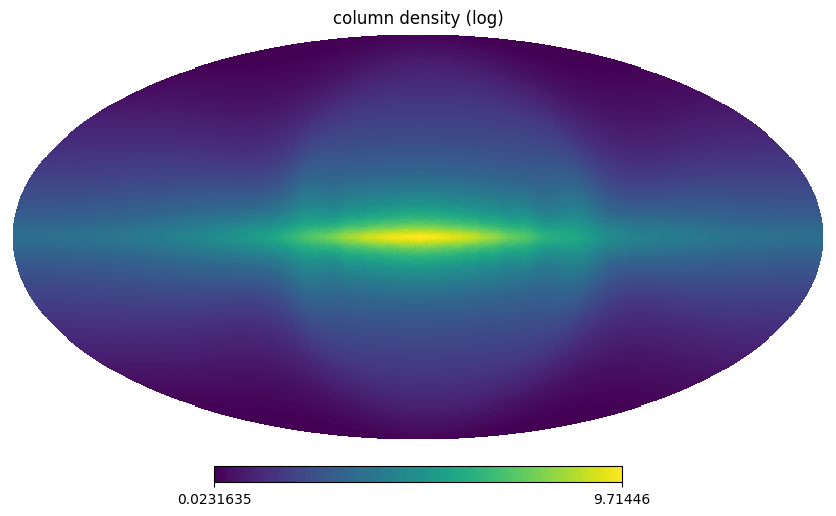

In [13]:
# change the amplitude of the density for this 4-spiral-arms component:
dd['ARM4'][0]['A_0'] = .1
gp.plot_sky_projection(dd)#,crange=[0.03,9.])
plt.show()

That's all for now on `GalacticProfile` module!

### 3. BFIELD: Galactic Magnetic field module

This module contains the implementation of several parameteric models to describe the regular, large-scale, Galactic Magnetic Field.
As for the `GalacticProfile` module, dedicated to populate the space with matter density following parametric prescriptions, the `BFIELD` module has been written so that models can be accessed at different level, either in an abstract way and in a more technical way if more efficient computations are needed.

Implemented models are:
- ASS: Axi-symmetric spiral model
- BSS: Bi-symmetric spiral model
- QSS: Quadri-symmetric spiral model
- BT: Bit-toroidal model
- CCR: Concentric Circular model
- RING: Ring (thick cylinder) model
- LSA: Logarithmic spiral arm model
- MLS: Modified logarithmic spiral arm model
- WMAP: model in Page et al. 2007 WMAP paper ($\equiv$ LSA)
- JAFFE: model in Jaffe et al. 2010 paper (composite)

and the `COMPO()` function enable the combination of any such "geometric" models through simple vector addition.

The visualization of the model (orientations of the magnetic field lines and field strength) is as simple as :


        MLS B field model has been computed with DEFAULT parameter values

    >>> Field amplitude has been computed with a
        0.05 [kpc] grid-spacing

        MLS B field model has been computed with DEFAULT parameter values


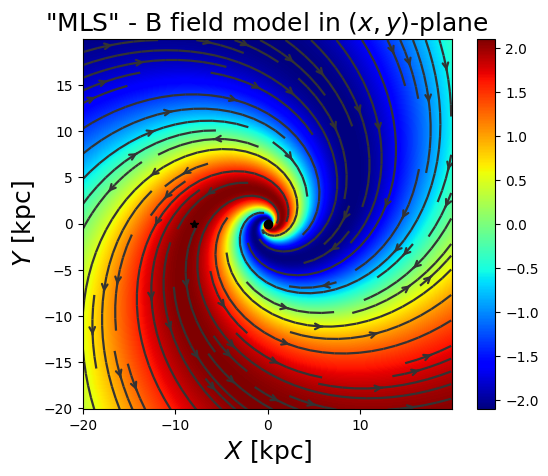


    >>> Field lines have been computed with a
        0.25 [kpc] grid-spacing using streamplot


In [14]:
bf.plot_galactic_Bfield_xy_slice({'MLS':{}},directional=True)
plt.show()

in which the `MLS` model is displayed with its default parameters and has been called by the dictionary. The optional argument `directional=True` has the effect of setting _negative strength_ values to $\mathbf{B}$ field vectors with clockwise rotation about the Galactic center and _positive strength_ values to counter-clockwise vectors. This is rather arbitrary but can help to visualize the field.


        JAFFE B field model has been computed with DEFAULT parameter values

    >>> Field amplitude has been computed with a
        0.05 [kpc] grid-spacing

        JAFFE B field model has been computed with DEFAULT parameter values


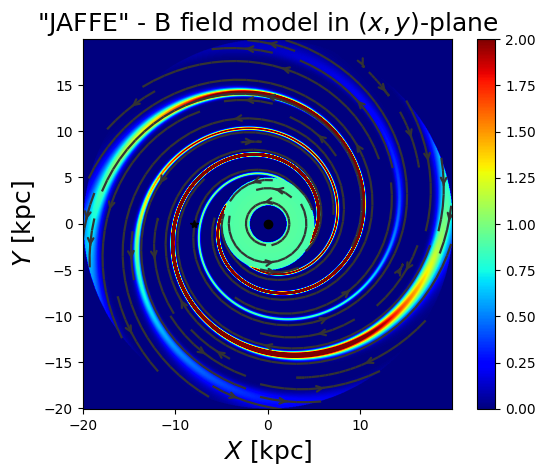


    >>> Field lines have been computed with a
        0.25 [kpc] grid-spacing using streamplot

        JAFFE B field model has been computed with DEFAULT parameter values

        JAFFE B field model has been computed with DEFAULT parameter values


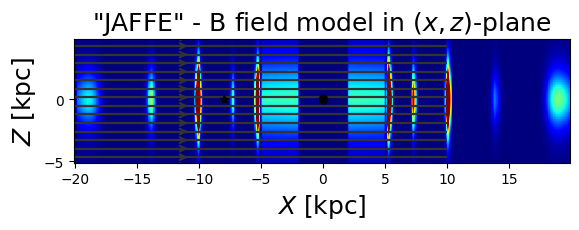


    The Galaxy Template has been built with:
        NSIDE =  64 
        radial_step =  0.2 kpc
        radial_max =  20.0 kpc

    The Galactic space is thus populated by 4915200 points
    distributed spherically around the Sun.
    
    Dot products between basis vectors have been computed

        JAFFE B field model has been computed with DEFAULT parameter values


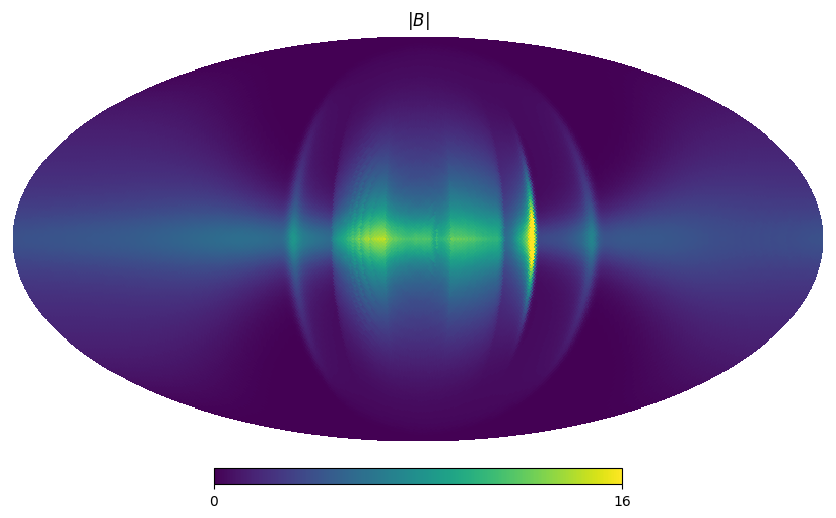

In [15]:
# cross-cut in XY plane
bf.plot_galactic_Bfield_xy_slice({'JAFFE':{}},crange=[0,2])
# cross-cut in XZ plane
bf.plot_galactic_Bfield_xz_slice({'JAFFE':{}},0.2,crange=[0,2])
# sky projection of B field strength integrated along the LOS
bf.plot_sky_projection({'JAFFE':{}},crange=[0.,16.])
plt.show()

As it is for  density distribution model, we have a `bf.BFielder()` function that takes coordinates at which to estimate the GMF and a dictionary with the name of the GMF model of interest on the names and values of the parameters, including for some, the possibility to change the functional form of coordinates.

To get the default parameter setting, the best is to call `bf.get_BfieldDefault(_name_of_the_field_model_)` which can be output if `output=True` is specified.

Again, the GMF configuration can be saved/loaded using `yaml` configuration files in the same way as with the `GalacticProfile` module.

**Notice** that the output 3D vector field will _always_ be expressed in cylindrical coordinate system centered on the Galactic center. Though, there are convenient function within the `BFIELD` and the `GalaxyBasics` modules that makes it possible to extract relevant quantities from the field to compute polarization observables, for example.

For example, to get the 3D vector field of the GMF expressed in the spherical coordinate system centered on the Sun of the `MLS` model (with default values), it is as simple as:

In [16]:
Bgal = bf.BFielder(XYZ_gal,{'MLS':{}})
#remember the computation of the dot products at the beginning?
# now we need them:
Br,Bt,Bp = gb.__gal2sun_vector(Bgal,dotproducts)


        MLS B field model has been computed with DEFAULT parameter values


`Br`, `Bt` and `Bp` are the vector components of the GMF in spherical coordinate system with base $(\mathbf{e}_r, \mathbf{e}_\theta, \mathbf{e}_\phi)$.  
From there, one can compute everything needed.

### 4. GalacticForegrounds: Generating polarization observables out of parameteric models

At then end of the day, one is able to generate observables of themal dust polarized emission just by passing dictionary to some function, as in the following example.

In [17]:
lsa = bf.getBFieldDefault('LSA',output=True)
I,Q,U = gf.IQU_dust_fromModels(dust_model,lsa)

{
	'LSA': {
		'B_0': 2.1,
		'B_amp_param': 8.0,
		'B_amp_type': 'cyl',
		'psi_0': 0.47123889803846897,
		'psi_1': 0.015707963267948967,
		'Xi_0': 0.4363323129985824,
		'z_0': 1.0,
		'rho_0': 8.0,
		'coord_format': 'cartesian'
	}
}

    The Galaxy Template has been built with:
        NSIDE =  64 
        radial_step =  0.2 kpc
        radial_max =  20.0 kpc

    The Galactic space is thus populated by 4915200 points
    distributed spherically around the Sun.
    
    Dot products between basis vectors have been computed


  -  Arm 1
  -  Arm 2
  -  Arm 3
  -  Arm 4
  -  Clump 1
  -  Loop 1
  -  Loop 2
  -  cylHalo 1


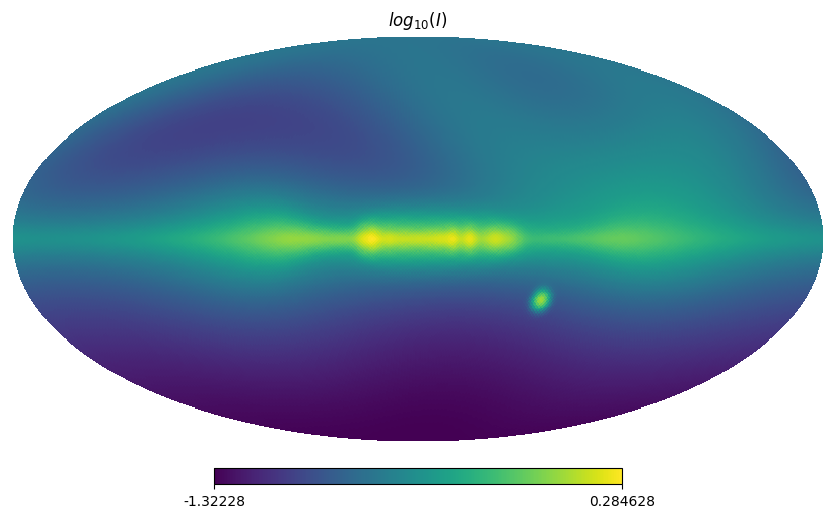

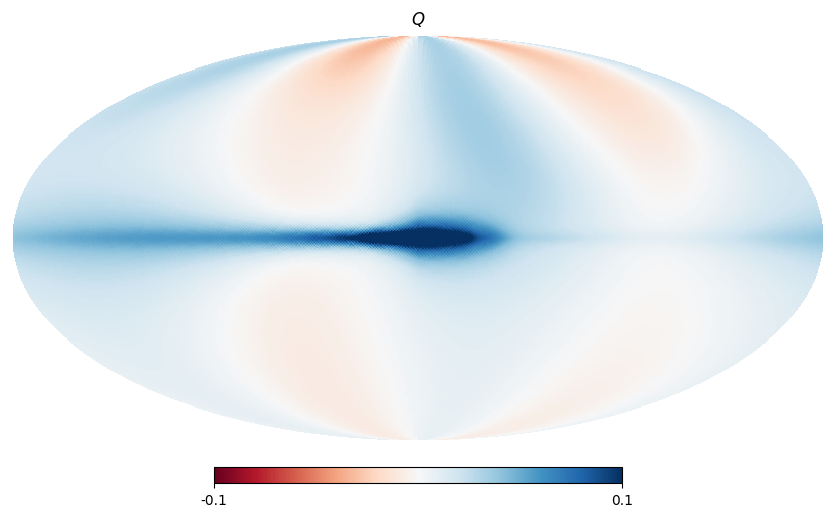

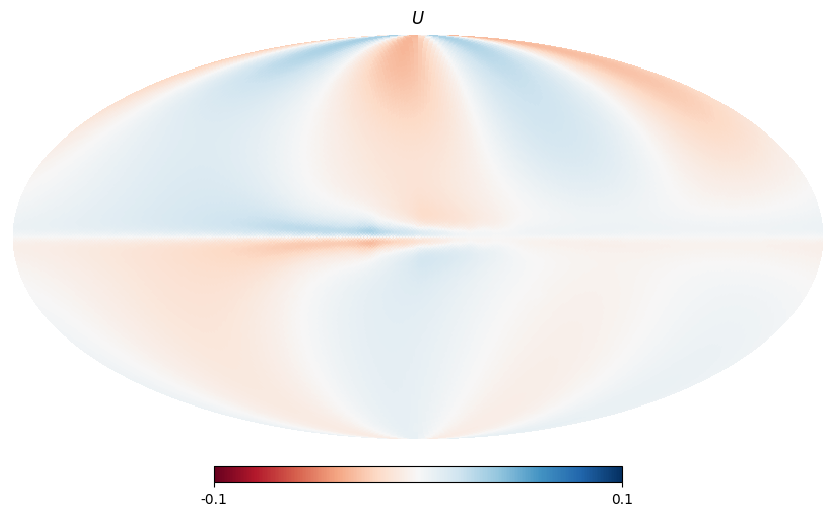

In [18]:
hp.mollview(np.log10(I),title=r'$log_{10}(I)$');
hp.mollview(Q,title=r'$Q$',cmap='RdBu',min=-.1,max=.1);
hp.mollview(U,title=r'$U$',cmap='RdBu',min=-.1,max=.1);
plt.show()